# Multiplication

Here we look at (my version of) the most general multiplier operator. This involves using [multiplication using the quantum Fourier transform](https://link.springer.com/article/10.1007/s11128-017-1603-1) (built upon the quantum Fourier transform addition operation from the previous notebook). 

Note that this operation is relatively computationally expensive and may require some more time to simulate than previous notebooks, as well as being a generally longer notebook itself. If playing with the inputs, I would suggest limiting them so that the output register does not exceed 11-12 qubits, otherwise you may be waiting a good while to see the result.

Here, we look into the operation that performs the following:

$$ |A\rangle^{\otimes n_A}|B\rangle^{\otimes n_B}|0\rangle^{\otimes n_C\le n_A+n_B} \rightarrow |A\rangle^{\otimes n_A}|B\rangle^{\otimes n_B}|A\times B\rangle^{\otimes n_C\le n_A+n_B} $$

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
import qiskit_tools as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

Let us first consider simply two positive numbers:

In [2]:
phase = True

digit_A = 5.25
digit_B = 7.5

print(digit_A,'x',digit_B,'=',digit_A*digit_B)

5.25 x 7.5 = 39.375


The requires integer, precision and total qubits of digit $A$ are:

In [3]:
nintA = qt.get_nint(digit_A)
npresA = qt.get_npres(digit_A)
nA = nintA + npresA

if phase:
    nA += 1

print(nA, nintA, npresA)

6 3 2


Similarly for digit $B$:

In [4]:
nintB = qt.get_nint(digit_B)
npresB = qt.get_npres(digit_B)
nB = nintB + npresB

if phase:
    nB += 1
print(nB, nintB, npresB)

5 3 1


The minimum requires bits for the product $C=A\times B$ are:

In [5]:
nintC = qt.get_nint(digit_A*digit_B)
npresC = qt.get_npres(digit_A*digit_B)
nC = nintC + npresC

if phase:
    nC += 1
print(nC, nintC, npresC)

10 6 3


The corresponding bit strings for these values are then:

In [6]:
binary_A = qt.my_binary_repr(digit_A, nA, nint=nintA, phase=phase)
binary_B = qt.my_binary_repr(digit_B, nB, nint=nintB, phase=phase)
binary_C = qt.my_binary_repr(digit_A*digit_B, nC, nint=nintC, phase=phase)

print(binary_A,binary_B,binary_C)

010101 01111 0100111011


Let's put these values into three separate qiskit quantum registers:

In [7]:
qregA = QuantumRegister(nA, 'A')
qregB = QuantumRegister(nB, 'B')
qregC = QuantumRegister(nC, 'C')
out_reg = ClassicalRegister(nC,'out_reg')
circ = QuantumCircuit(qregA, qregB, qregC, out_reg)

In [8]:
A_gate = qt.input_bits_to_qubits(binary_A, circ, reg=qregA, wrap=True)
B_gate = qt.input_bits_to_qubits(binary_B, circ, reg=qregB, wrap=True)
circ.append(A_gate, qregA);
circ.append(B_gate, qregB);

Then apply the simple quantum Fourier transform multiplication operation defined [here](https://link.springer.com/article/10.1007/s11128-017-1603-1):

In [9]:
mult_gate = qt.QFTMultiply(circ, qregA, qregB, qregC, nint1=nintA, nint2=nintB, nint3=nintC, phase=True, wrap=True)
circ.append(mult_gate, [*qregA, *qregB, *qregC]);

In [10]:
circ.measure(qregC, out_reg);

Lets see our circuit:

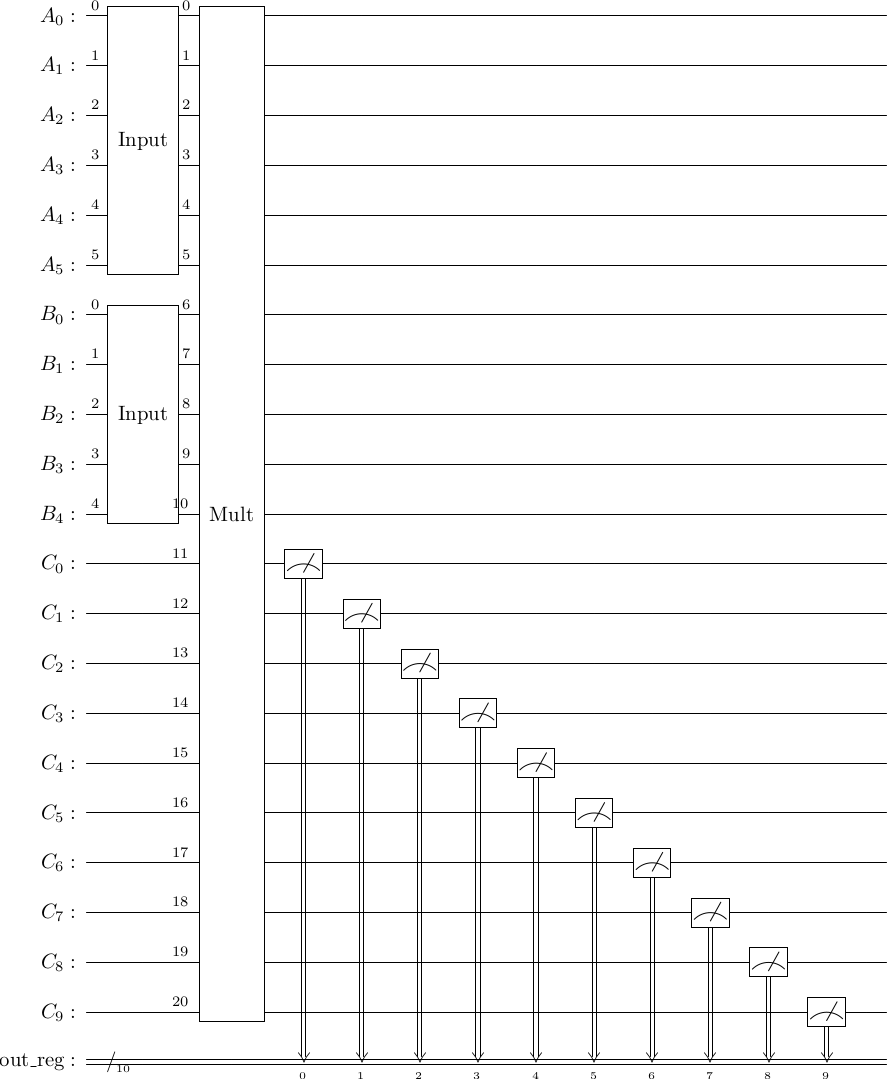

In [11]:
circ.draw('latex')

Lets now measure some simulation realisations of this circuit and see the result:

In [12]:
shots=10
emulator = Aer.get_backend('qasm_simulator')
job = execute(circ, emulator, shots=shots )
hist = job.result().get_counts()

In [13]:
print('Target:')
print(digit_B,'x',digit_A,'=',digit_B*digit_A,'->',binary_C)

print('Result:')
for label in hist.keys():
    print(digit_B,'x',digit_A,'=',qt.bin_to_dec(label, nint=nintC, phase=phase),'->',label,'with probability',float(hist[label])/shots)

Target:
7.5 x 5.25 = 39.375 -> 0100111011
Result:
7.5 x 5.25 = 39.375 -> 0100111011 with probability 1.0


Great! We get the target value back. This appears to work well, but if we are generalising then we need to consider other inputs.

Let's try some negative numbers. Here I have set $B$ to a negative value:

In [14]:
phase = True

digit_A = 5.25
digit_B = -7.5

print(digit_A,'x',digit_B,'=',digit_A*digit_B)

5.25 x -7.5 = -39.375


Resulting in bit strings:

In [15]:
binary_A = qt.my_binary_repr(digit_A, nA, nint=nintA, phase=phase)
binary_B = qt.my_binary_repr(digit_B, nB, nint=nintB, phase=phase)
binary_C = qt.my_binary_repr(digit_A*digit_B, nC, nint=nintC, phase=phase)

print(binary_A,binary_B,binary_C)

010101 10001 1011000101


Let's run the same circuit as before and sample some results:

In [16]:
qregA = QuantumRegister(nA, 'A')
qregB = QuantumRegister(nB, 'B')
qregC = QuantumRegister(nC, 'C')
out_reg = ClassicalRegister(nC,'out_reg')
circ = QuantumCircuit(qregA, qregB, qregC, out_reg)

A_gate = qt.input_bits_to_qubits(binary_A, circ, reg=qregA, wrap=True)
B_gate = qt.input_bits_to_qubits(binary_B, circ, reg=qregB, wrap=True)
circ.append(A_gate, qregA);
circ.append(B_gate, qregB);

mult_gate = qt.QFTMultiply(circ, qregA, qregB, qregC, nint1=nintA, nint2=nintB, nint3=nintC, phase=True, wrap=True)
circ.append(mult_gate, [*qregA, *qregB, *qregC]);

circ.measure(qregC, out_reg);

In [17]:
shots=10
emulator = Aer.get_backend('qasm_simulator')
job = execute(circ, emulator, shots=shots )
hist = job.result().get_counts()

In [18]:
print('Target:')
print(digit_B,'x',digit_A,'=',digit_B*digit_A,'->',binary_C)

print('Result:')
for label in hist.keys():
    print(digit_B,'x',digit_A,'=',qt.bin_to_dec(label, nint=nintC, phase=phase),'->',label,'with probability',float(hist[label])/shots)

Target:
-7.5 x 5.25 = -39.375 -> 1011000101
Result:
-7.5 x 5.25 = 44.625 -> 0101100101 with probability 1.0


Oh no! We end up with the wrong result. We can see that the straight forward multiplier does not handle twos-complement notation as intended. 

We can fix this by performing the following sequence of operations:

   1. Switching out of the twos-complement notation into a signed-magnitude notation in registers $A$ and $B$ by performing the twos-complement operation on the magnitude components conditioned on the phase bit of each register. 
   2. Performing the standard quantum Fourier transform mutiplication.
   3. Perform a twos-complement operation on the magnitude component of register $C$ if register $A$ OR register $B$ is negative (not AND). 
   4. Flip the phase qubit of register $C$ if register $A$ or $B$ is negative.    5. Revert registers $A$ and $B$ back to the twos-complement representation by performing the operation in step 1 again (the twos-complement operation is its own inverse). 

In [19]:
qregA = QuantumRegister(nA, 'A')
qregB = QuantumRegister(nB, 'B')
qregC = QuantumRegister(nC, 'C')
out_reg = ClassicalRegister(nC,'out_reg')
circ = QuantumCircuit(qregA, qregB, qregC, out_reg)

# Input the A and B binary strings into their registers
A_gate = qt.input_bits_to_qubits(binary_A, circ, reg=qregA, wrap=True)
B_gate = qt.input_bits_to_qubits(binary_B, circ, reg=qregB, wrap=True)
circ.append(A_gate, qregA);
circ.append(B_gate, qregB);

circ.barrier()

# Define the twos-complement operations
tc_gate_A = qt.TwosCompliment(circ, qregA[:-1], wrap=True).control(1)
tc_gate_B = qt.TwosCompliment(circ, qregB[:-1], wrap=True).control(1)
tc_gate_C = qt.TwosCompliment(circ, qregC[:-1], wrap=True).control(2)

# Add the twos-complement operations to convert registers A and B to sign-magnitude notation
circ.append(tc_gate_A, [qregA[-1], *qregA[:-1]]);
circ.append(tc_gate_B, [qregB[-1], *qregB[:-1]]);

circ.barrier()

# Apply simple QFT multiplication
mult_gate = qt.QFTMultiply(circ, qregA[:-1], qregB[:-1], qregC[:-1], nint1=nintA, nint2=nintB, nint3=nintC, wrap=True)
circ.append(mult_gate, [*qregA[:-1], *qregB[:-1], *qregC[:-1]]);

circ.barrier()

# If register A is positive, but register B is negative, then twos-complement operator on C
circ.x(qregA[-1]);
circ.append(tc_gate_C, [qregA[-1], qregB[-1], *qregC[:-1]]);
circ.x(qregA[-1]);

# If register B is positive, but register A is negative, then twos-complement operator on C
circ.x(qregB[-1]);
circ.append(tc_gate_C, [qregA[-1], qregB[-1], *qregC[:-1]]);
circ.x(qregB[-1]);

circ.barrier()

# If A is negative flip phase qubit of C, and if B is negative flip phase qubit of C
circ.cx(qregA[-1], qregC[-1]);
circ.cx(qregB[-1], qregC[-1]);

circ.barrier()

# Restore registers A and B to original twos-complement notation
circ.append(tc_gate_A, [qregA[-1], *qregA[:-1]]);
circ.append(tc_gate_B, [qregB[-1], *qregB[:-1]]);

circ.barrier()

circ.measure(qregC, out_reg);

Our circuit looks like this:

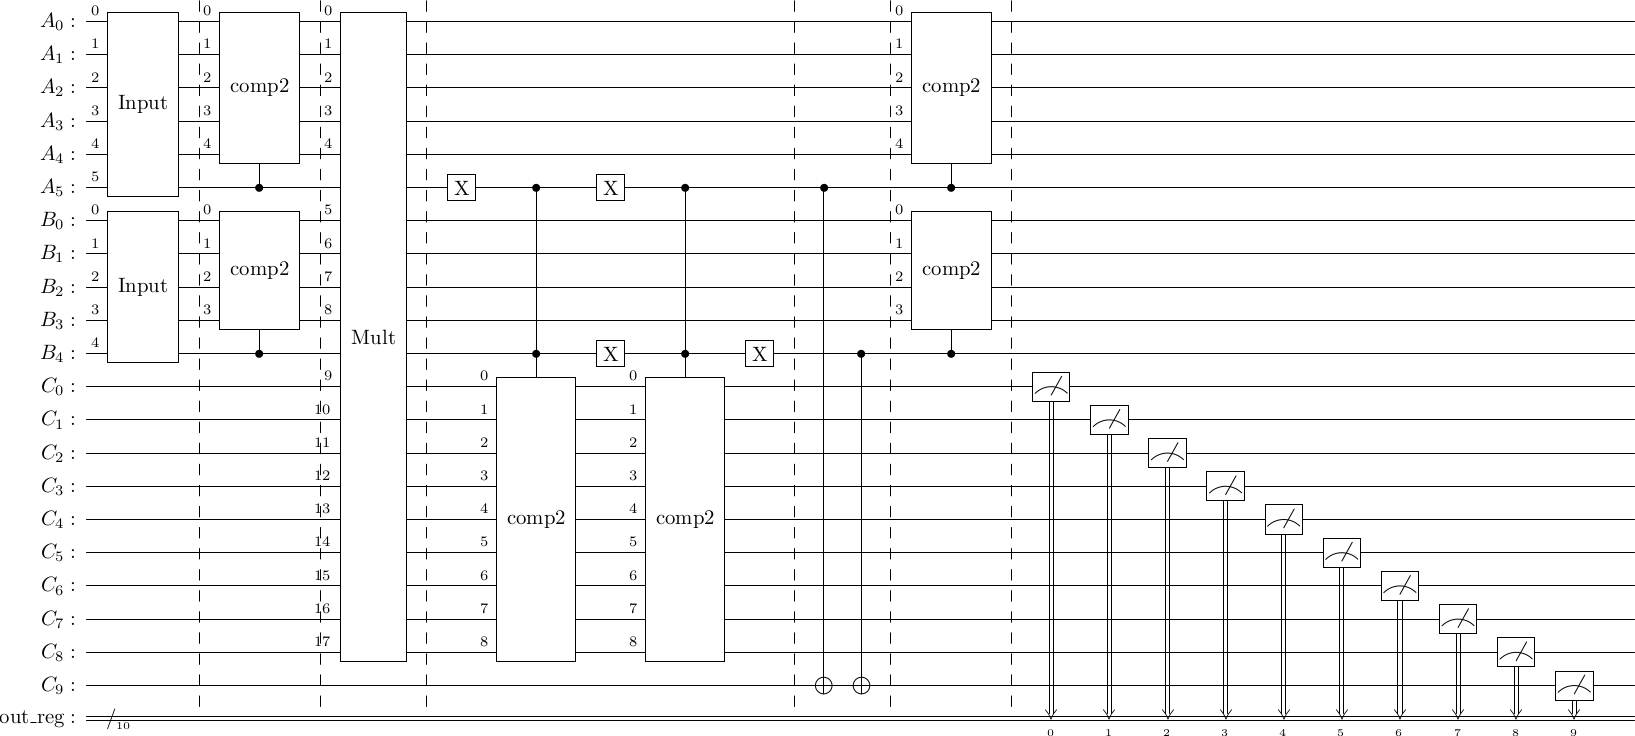

In [20]:
circ.draw('latex')

In [21]:
shots=10
emulator = Aer.get_backend('qasm_simulator')
job = execute(circ, emulator, shots=shots )
hist = job.result().get_counts()

In [22]:
print('Target:')
print(digit_B,'x',digit_A,'=',digit_B*digit_A,'->',binary_C)

print('Result:')
for label in hist.keys():
    print(digit_B,'x',digit_A,'=',qt.bin_to_dec(label, nint=nintC, phase=phase),'->',label,'with probability',float(hist[label])/shots)

Target:
-7.5 x 5.25 = -39.375 -> 1011000101
Result:
-7.5 x 5.25 = -39.375 -> 1011000101 with probability 1.0


Now this has fixed our result to equal the desired solution!

However, we have not considered all possible inputs. Let us now set one of the digits to equal 0 (choosing the first register) and the other value be negative:

In [23]:
phase = True

digit_A = 0.
digit_B = -7.5

print(digit_A,'x',digit_B,'=',digit_A*digit_B)

0.0 x -7.5 = -0.0


In [24]:
binary_A = qt.my_binary_repr(digit_A, nA, nint=nintA, phase=phase)
binary_B = qt.my_binary_repr(digit_B, nB, nint=nintB, phase=phase)
binary_C = qt.my_binary_repr(digit_A*digit_B, nC, nint=nintC, phase=phase)

print(binary_A,binary_B,binary_C)

000000 10001 0000000000


Applying the same circuit as before:

In [25]:
qregA = QuantumRegister(nA, 'A')
qregB = QuantumRegister(nB, 'B')
qregC = QuantumRegister(nC, 'C')
out_reg = ClassicalRegister(nC,'out_reg')
circ = QuantumCircuit(qregA, qregB, qregC, out_reg)

# Input the A and B binary strings into their registers
A_gate = qt.input_bits_to_qubits(binary_A, circ, reg=qregA, wrap=True)
B_gate = qt.input_bits_to_qubits(binary_B, circ, reg=qregB, wrap=True)
circ.append(A_gate, qregA);
circ.append(B_gate, qregB);

circ.barrier()

# Define the twos-complement operations
tc_gate_A = qt.TwosCompliment(circ, qregA[:-1], wrap=True).control(1)
tc_gate_B = qt.TwosCompliment(circ, qregB[:-1], wrap=True).control(1)
tc_gate_C = qt.TwosCompliment(circ, qregC[:-1], wrap=True).control(2)

# Add the twos-complement operations to convert registers A and B to sign-magnitude notation
circ.append(tc_gate_A, [qregA[-1], *qregA[:-1]]);
circ.append(tc_gate_B, [qregB[-1], *qregB[:-1]]);

circ.barrier()

# Apply simple QFT multiplication
mult_gate = qt.QFTMultiply(circ, qregA[:-1], qregB[:-1], qregC[:-1], nint1=nintA, nint2=nintB, nint3=nintC, wrap=True)
circ.append(mult_gate, [*qregA[:-1], *qregB[:-1], *qregC[:-1]]);

circ.barrier()

# If register A is positive, but register B is negative, then twos-complement operator on C
circ.x(qregA[-1]);
circ.append(tc_gate_C, [qregA[-1], qregB[-1], *qregC[:-1]]);
circ.x(qregA[-1]);

# If register B is positive, but register A is negative, then twos-complement operator on C
circ.x(qregB[-1]);
circ.append(tc_gate_C, [qregA[-1], qregB[-1], *qregC[:-1]]);
circ.x(qregB[-1]);

circ.barrier()

# If A is negative flip phase qubit of C, and if B is negative flip phase qubit of C
circ.cx(qregA[-1], qregC[-1]);
circ.cx(qregB[-1], qregC[-1]);

circ.barrier()

# Restore registers A and B to original twos-complement notation
circ.append(tc_gate_A, [qregA[-1], *qregA[:-1]]);
circ.append(tc_gate_B, [qregB[-1], *qregB[:-1]]);

circ.barrier()

circ.measure(qregC, out_reg);

In [26]:
shots=10
emulator = Aer.get_backend('qasm_simulator')
job = execute(circ, emulator, shots=shots )
hist = job.result().get_counts()

In [27]:
print('Target:')
print(digit_B,'x',digit_A,'=',digit_B*digit_A,'->',binary_C)

print('Result:')
for label in hist.keys():
    print(digit_B,'x',digit_A,'=',qt.bin_to_dec(label, nint=nintC, phase=phase),'->',label,'with probability',float(hist[label])/shots)

Target:
-7.5 x 0.0 = -0.0 -> 0000000000
Result:
-7.5 x 0.0 = -64.0 -> 1000000000 with probability 1.0


Now gives the wrong result..! It is because of that pesky negative zero. Some extra consideration must be made to consider this.

Let us now fix this issue by adding two additional conditions:

   1. If all qubits in register $A$ are 0 and the $B$ is negative then flip the phase of $C$.
   2. If all qubits in register $B$ are 0 and the $A$ is negative then flip the phase of $C$.
   
This can be done through multi-controlled NOT gates:

In [28]:
qregA = QuantumRegister(nA, 'A')
qregB = QuantumRegister(nB, 'B')
qregC = QuantumRegister(nC, 'C')
out_reg = ClassicalRegister(nC,'out_reg')
circ = QuantumCircuit(qregA, qregB, qregC, out_reg)

# Input the A and B binary strings into their registers
A_gate = qt.input_bits_to_qubits(binary_A, circ, reg=qregA, wrap=True)
B_gate = qt.input_bits_to_qubits(binary_B, circ, reg=qregB, wrap=True)
circ.append(A_gate, qregA);
circ.append(B_gate, qregB);

circ.barrier()

# Define the twos-complement operations
tc_gate_A = qt.TwosCompliment(circ, qregA[:-1], wrap=True).control(1)
tc_gate_B = qt.TwosCompliment(circ, qregB[:-1], wrap=True).control(1)
tc_gate_C = qt.TwosCompliment(circ, qregC[:-1], wrap=True).control(2)

# Add the twos-complement operations to convert registers A and B to sign-magnitude notation
circ.append(tc_gate_A, [qregA[-1], *qregA[:-1]]);
circ.append(tc_gate_B, [qregB[-1], *qregB[:-1]]);

circ.barrier()

# Apply simple QFT multiplication
mult_gate = qt.QFTMultiply(circ, qregA[:-1], qregB[:-1], qregC[:-1], nint1=nintA, nint2=nintB, nint3=nintC, wrap=True)
circ.append(mult_gate, [*qregA[:-1], *qregB[:-1], *qregC[:-1]]);

circ.barrier()

# If register A is positive, but register B is negative, then twos-complement operator on C
circ.x(qregA[-1]);
circ.append(tc_gate_C, [qregA[-1], qregB[-1], *qregC[:-1]]);
circ.x(qregA[-1]);

# If register B is positive, but register A is negative, then twos-complement operator on C
circ.x(qregB[-1]);
circ.append(tc_gate_C, [qregA[-1], qregB[-1], *qregC[:-1]]);
circ.x(qregB[-1]);

circ.barrier()

# If A is negative flip phase qubit of C, and if B is negative flip phase qubit of C
circ.cx(qregA[-1], qregC[-1]);
circ.cx(qregB[-1], qregC[-1]);

circ.barrier()

# Restore registers A and B to original twos-complement notation
circ.append(tc_gate_A, [qregA[-1], *qregA[:-1]]);
circ.append(tc_gate_B, [qregB[-1], *qregB[:-1]]);

circ.barrier()

# Flip register A
for qubit in np.arange(nA):
    circ.x(qregA[qubit]);

# If register A is all zeros and phase of B is negative, then flip the phase of C
circ.mcx([*qregA, qregB[-1]], qregC[-1], mode='noancilla')

# Flip back register A
for qubit in np.arange(nA):
    circ.x(qregA[qubit]);

circ.barrier()
    
# Flip register B
for qubit in np.arange(nB):
    circ.x(qregB[qubit]);
    
# If register B is all zeros and phase of A is negative, then flip the phase of C
circ.mcx([*qregB, qregA[-1]], qregC[-1], mode='noancilla')

# Flip back register B
for qubit in np.arange(nB):
    circ.x(qregB[qubit]);

circ.barrier()

circ.measure(qregC, out_reg);

This circuit now looks like:

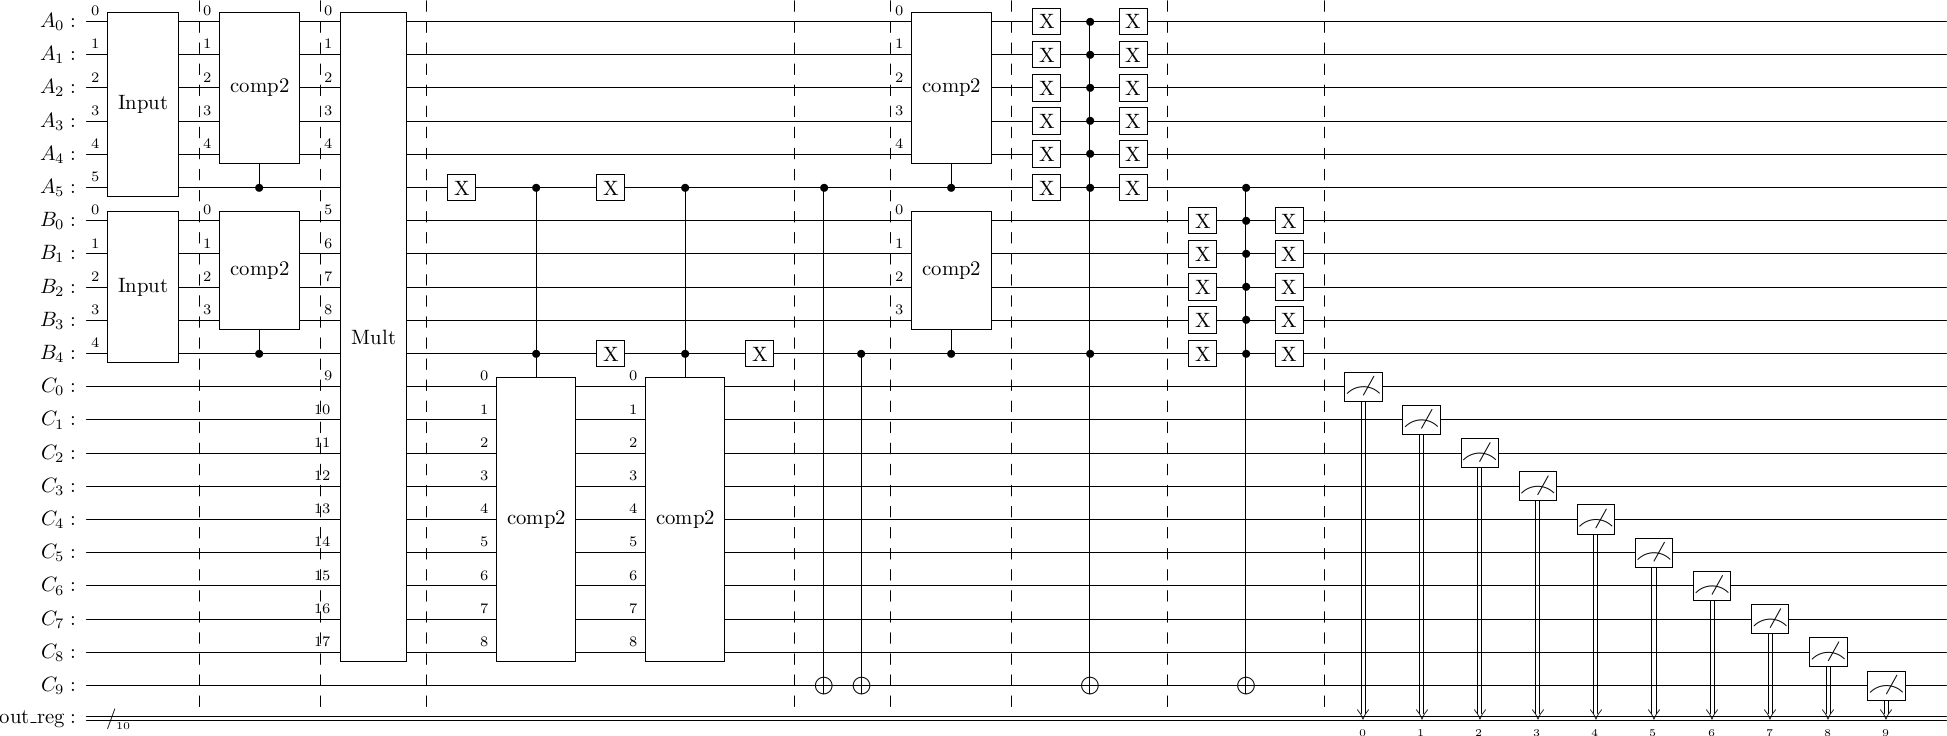

In [29]:
circ.draw('latex')

In [30]:
shots=10
emulator = Aer.get_backend('qasm_simulator')
job = execute(circ, emulator, shots=shots )
hist = job.result().get_counts()

In [31]:
print('Target:')
print(digit_B,'x',digit_A,'=',digit_B*digit_A,'->',binary_C)

print('Result:')
for label in hist.keys():
    print(digit_B,'x',digit_A,'=',qt.bin_to_dec(label, nint=nintC, phase=phase),'->',label,'with probability',float(hist[label])/shots)

Target:
-7.5 x 0.0 = -0.0 -> 0000000000
Result:
-7.5 x 0.0 = 0.0 -> 0000000000 with probability 1.0


This now fixes the negative zero issue! 

Finally, let's return to a previous example:

In [32]:
phase = True

digit_A = 5.25
digit_B = -7.5

print(digit_A,'x',digit_B,'=',digit_A*digit_B)

5.25 x -7.5 = -39.375


In [33]:
binary_A = qt.my_binary_repr(digit_A, nA, nint=nintA, phase=phase)
binary_B = qt.my_binary_repr(digit_B, nB, nint=nintB, phase=phase)
binary_C = qt.my_binary_repr(digit_A*digit_B, nC, nint=nintC, phase=phase)

print(binary_A,binary_B,binary_C)

010101 10001 1011000101


We can use the function `QFTMultPhase` to perform this generalised version of multiplication:

In [34]:
qregA = QuantumRegister(nA, 'A')
qregB = QuantumRegister(nB, 'B')
qregC = QuantumRegister(nC, 'C')
out_reg = ClassicalRegister(nC,'out_reg')
circ = QuantumCircuit(qregA, qregB, qregC, out_reg)

A_gate = qt.input_bits_to_qubits(binary_A, circ, reg=qregA, wrap=True)
B_gate = qt.input_bits_to_qubits(binary_B, circ, reg=qregB, wrap=True)
circ.append(A_gate, qregA);
circ.append(B_gate, qregB);

mult_gate = qt.QFTMultPhase(circ, qregA, qregB, qregC, nint1=nintA, nint2=nintB, nint3=nintC, wrap=True)
circ.append(mult_gate, [*qregA, *qregB, *qregC]);

circ.measure(qregC, out_reg);

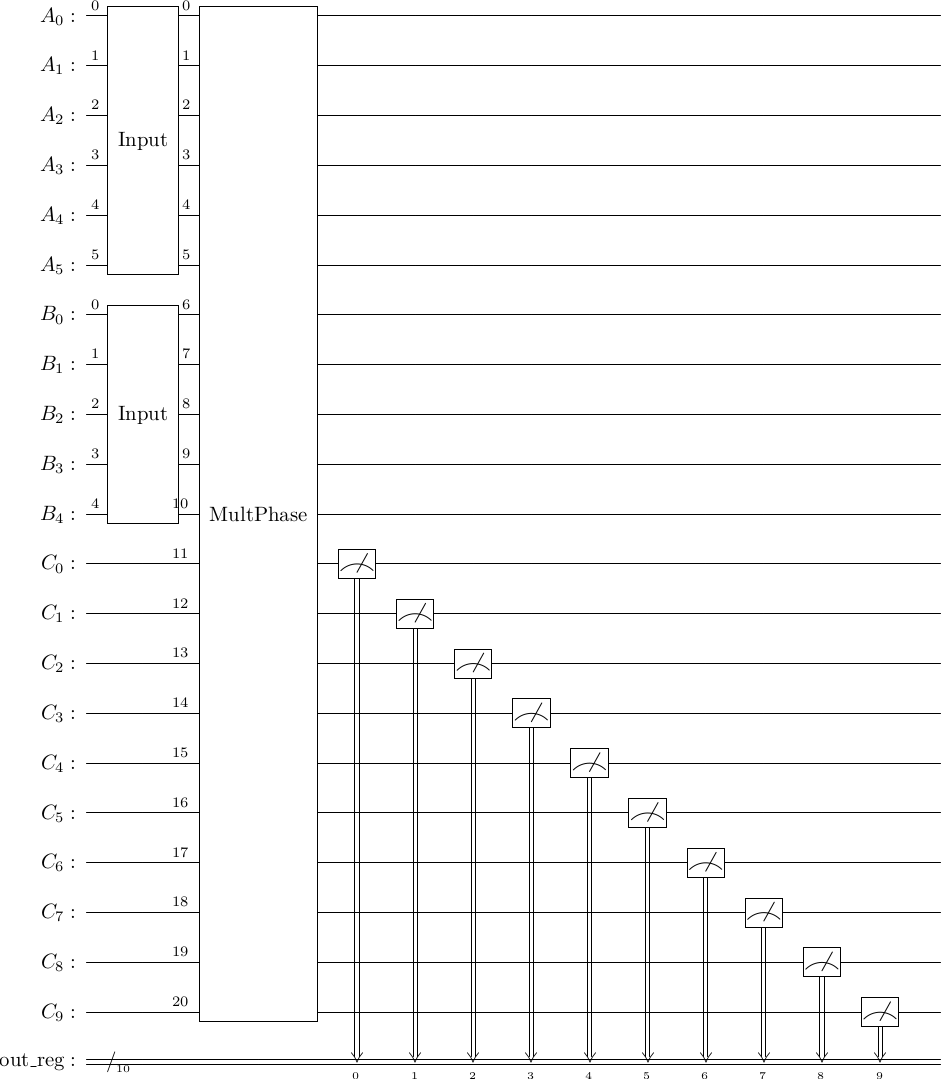

In [35]:
circ.draw(output='latex')

In [36]:
shots=10
emulator = Aer.get_backend('qasm_simulator')
job = execute(circ, emulator, shots=shots )
hist = job.result().get_counts()

In [37]:
print('Target:')
print(digit_B,'x',digit_A,'=',digit_B*digit_A,'->',binary_C)

print('Result:')
for label in hist.keys():
    print(digit_B,'x',digit_A,'=',qt.bin_to_dec(label, nint=nintC, phase=phase),'->',label,'with probability',float(hist[label])/shots)

Target:
-7.5 x 5.25 = -39.375 -> 1011000101
Result:
-7.5 x 5.25 = -39.375 -> 1011000101 with probability 1.0


And recover the desired solution. 

You may be asking 'why are you working in twos-complement notation in the first place? Why not work in phase-magnitude and then not worry about converting to and from twos-complement, and interpret negative zero as zero?'. This is a fair question. We can use the sign-magnitude representation to simplify the problem by setting `signmag1=True`, `signmag2=True` and `signmag3=True` as follows:

In [38]:
phase = True
signmag = True

digit_A = -5.25
digit_B = 0

print(digit_A,'x',digit_B,'=',digit_A*digit_B)

-5.25 x 0 = -0.0


In [39]:
binary_A = qt.my_binary_repr(digit_A, nA, nint=nintA, phase=phase, signmag=signmag)
binary_B = qt.my_binary_repr(digit_B, nB, nint=nintB, phase=phase, signmag=signmag)
binary_C = qt.my_binary_repr(digit_A*digit_B, nC, nint=nintC, phase=phase, signmag=signmag)

print(binary_A,binary_B,binary_C)

110101 00000 0000000000


In [40]:
qregA = QuantumRegister(nA, 'A')
qregB = QuantumRegister(nB, 'B')
qregC = QuantumRegister(nC, 'C')
out_reg = ClassicalRegister(nC,'out_reg')
circ = QuantumCircuit(qregA, qregB, qregC, out_reg)

A_gate = qt.input_bits_to_qubits(binary_A, circ, reg=qregA, wrap=True)
B_gate = qt.input_bits_to_qubits(binary_B, circ, reg=qregB, wrap=True)
circ.append(A_gate, qregA);
circ.append(B_gate, qregB);

mult_gate = qt.QFTMultPhase(circ, qregA, qregB, qregC, nint1=nintA, nint2=nintB, nint3=nintC, wrap=True, signmag1=True, signmag2=True, signmag3=True)
circ.append(mult_gate, [*qregA, *qregB, *qregC]);

circ.measure(qregC, out_reg);

We indicate that the input is written using the sign-magnitude representation rather than the twos-complement notation using `signmag1=True`, `signmag2=True` and `signmag3=True`. This reduced the circuit to simply:

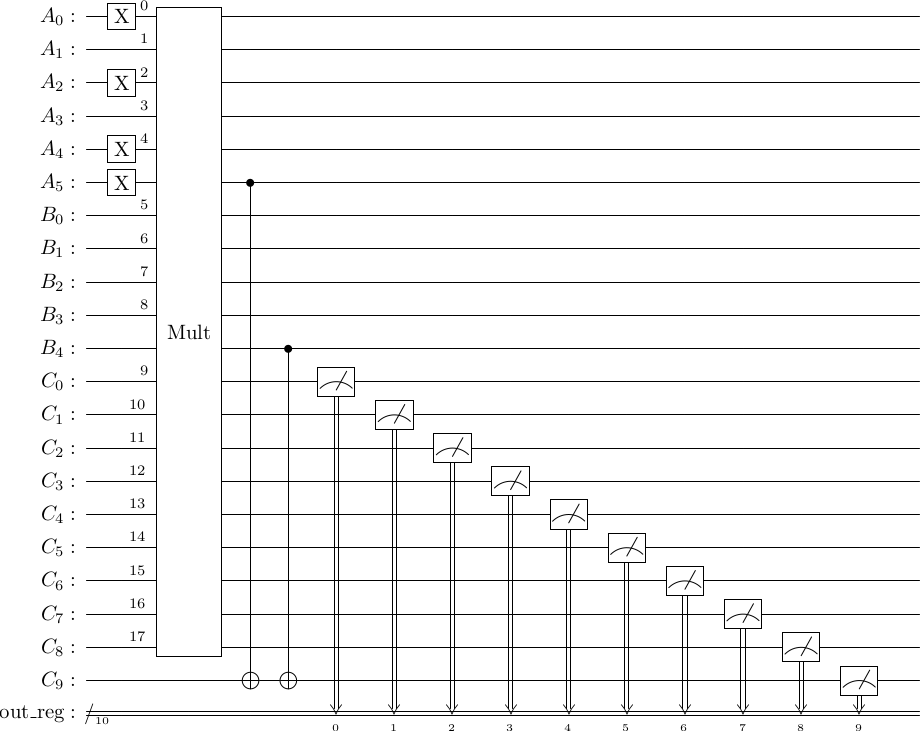

In [41]:
circ.decompose(reps=1).draw(output='latex')

In [42]:
shots=10
emulator = Aer.get_backend('qasm_simulator')
job = execute(circ, emulator, shots=shots )
hist = job.result().get_counts()

In [43]:
print('Target:')
print(digit_B,'x',digit_A,'=',digit_B*digit_A,'->',binary_C)

print('Result:')
for label in hist.keys():
    print(digit_B,'x',digit_A,'=',qt.bin_to_dec(label, nint=nintC, phase=phase, signmag=signmag),'->',label,'with probability',float(hist[label])/shots)

Target:
0 x -5.25 = -0.0 -> 0000000000
Result:
0 x -5.25 = -0.0 -> 1000000000 with probability 1.0


We see that we recover the correct answer, however it is negative zero value that is recovered and not actual zero. To recover zero, we have to state `poszero=True`:

In [44]:
phase = True
signmag = True

digit_A = -5.25
digit_B = 0

print(digit_A,'x',digit_B,'=',digit_A*digit_B)

-5.25 x 0 = -0.0


In [45]:
binary_A = qt.my_binary_repr(digit_A, nA, nint=nintA, phase=phase, signmag=signmag)
binary_B = qt.my_binary_repr(digit_B, nB, nint=nintB, phase=phase, signmag=signmag)
binary_C = qt.my_binary_repr(digit_A*digit_B, nC, nint=nintC, phase=phase, signmag=signmag)

print(binary_A,binary_B,binary_C)

110101 00000 0000000000


In [46]:
qregA = QuantumRegister(nA, 'A')
qregB = QuantumRegister(nB, 'B')
qregC = QuantumRegister(nC, 'C')
out_reg = ClassicalRegister(nC,'out_reg')
circ = QuantumCircuit(qregA, qregB, qregC, out_reg)

A_gate = qt.input_bits_to_qubits(binary_A, circ, reg=qregA, wrap=True)
B_gate = qt.input_bits_to_qubits(binary_B, circ, reg=qregB, wrap=True)
circ.append(A_gate, qregA);
circ.append(B_gate, qregB);

circ = qt.QFTMultPhase(circ, qregA, qregB, qregC, nint1=nintA, nint2=nintB, nint3=nintC, poszero=True, signmag1=True, signmag2=True, signmag3=True)

circ.measure(qregC, out_reg);

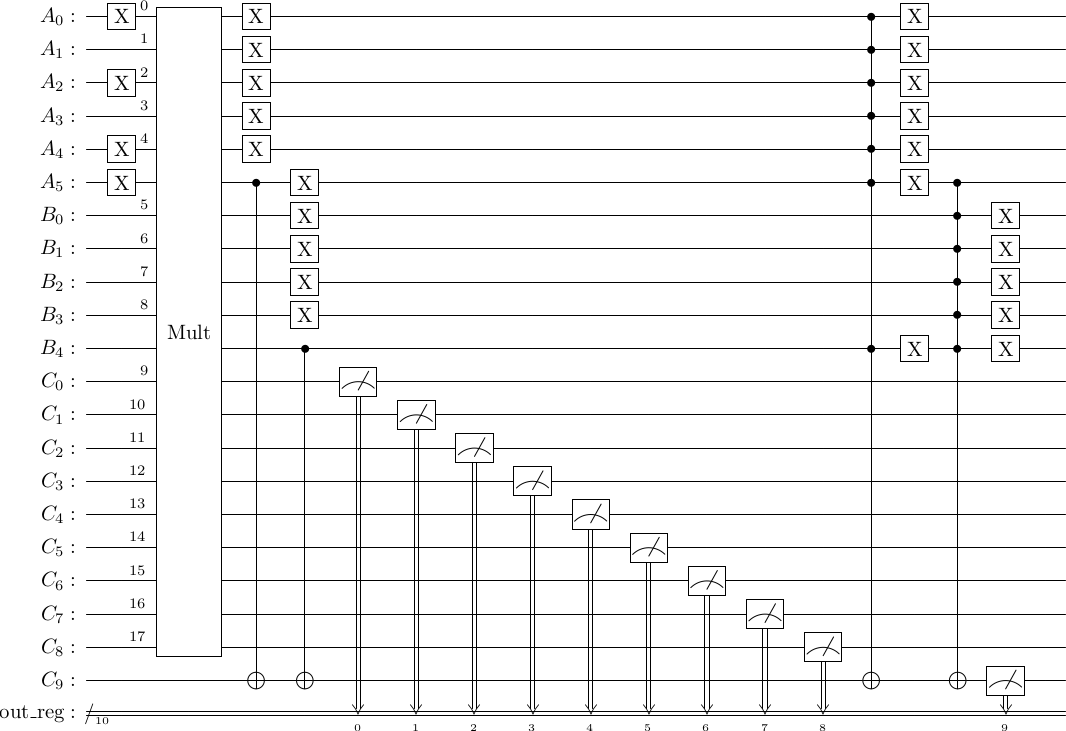

In [47]:
circ.decompose(reps=1).draw(output='latex')

In [48]:
shots=10
emulator = Aer.get_backend('qasm_simulator')
job = execute(circ, emulator, shots=shots )
hist = job.result().get_counts()

In [49]:
print('Target:')
print(digit_B,'x',digit_A,'=',digit_B*digit_A,'->',binary_C)

print('Result:')
for label in hist.keys():
    print(digit_B,'x',digit_A,'=',qt.bin_to_dec(label, nint=nintC, phase=phase, signmag=signmag),'->',label,'with probability',float(hist[label])/shots)

Target:
0 x -5.25 = -0.0 -> 0000000000
Result:
0 x -5.25 = 0.0 -> 0000000000 with probability 1.0


### Tasks:

This generalised multiplication operation is not optimal. I leave here some points on improvement.

1. Can the twos-complement multiplication be generally simplified? 
2. With the addition of even a single auxillary qubit, how much more efficiently can the multiplication be performed in?
3. Currently the QFT and iQFT only sandwich the core multiplication operation and not any of the additional procedures. Can the general multiplication operation be performed with a QFT at the beginning and an iQFT at the end? If a sequence of arithmetic operations are performed this would allow them to all be performed within a single QFT-iQFT sandwich.